In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

import requests
from urllib.parse import urlencode

Итак, настало время провести свой первый A/B тест.

Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

### Описание данных  
order_id - id заказа  
delivery_time - время доставки в минутах  
district - район доставки  
experiment_group - экспериментальная группа  

In [2]:
# Ссылка с данными о проведенном тесте
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/v5-lEOh3BCIYoQ'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [3]:
# Загружаем датасет
delivery_pizza = pd.read_csv(download_url)

In [4]:
delivery_pizza.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
# Смотрим данные столбцов
delivery_pizza.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [6]:
# Проверяем наличие пустых значений в данных
delivery_pizza.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

Сформулируем гипотезы для А/В теста:  
Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет  
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Посмотрим как данные распределены в контрольной и тестовой группах

In [7]:
control = delivery_pizza.query('experiment_group == "control"')

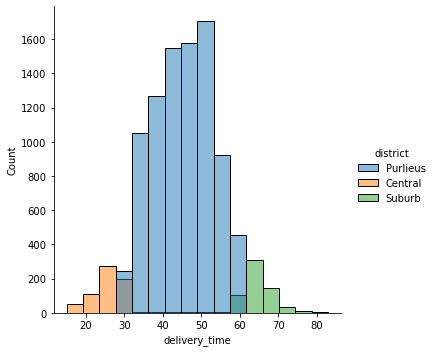

In [8]:
# Распределение количества доставок по времени доставки в контрольной группе
sns.displot(control, x='delivery_time', hue='district', bins=16)
plt.show()

In [9]:
test = delivery_pizza.query('experiment_group == "test"')

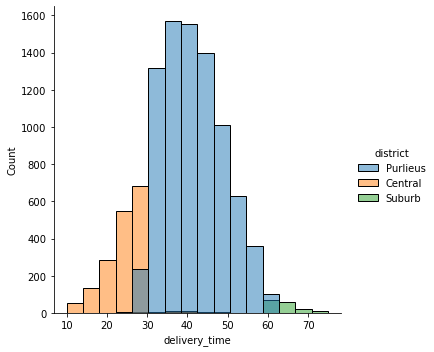

In [10]:
# Распределение количества доставок по времени доставки в тестовой группе
sns.displot(test, x='delivery_time', hue='district', bins=16)
plt.show()

Проверим распределения в тестовой и контрольной группах на нормальность с помощью теста Шапиро-Уилка. Возьмем по 1000 случайных испытуемых из группы, так как тест плохо работает на больших выборках

In [11]:
test_1000 = test['delivery_time'].sample(1000)
scipy.stats.shapiro(test_1000)

ShapiroResult(statistic=0.9971563816070557, pvalue=0.07400888949632645)

In [12]:
control_1000 = control['delivery_time'].sample(1000)
scipy.stats.shapiro(control_1000)

ShapiroResult(statistic=0.997620165348053, pvalue=0.15728873014450073)

Обе группы распределены нормально

std_control = np.std(control)['delivery_time']

std_test = np.std(test)['delivery_time']

Так как данные распределены нормально и нет аномалий в данных, то мы можем воспользоваться тестом Стьюдента для проверки нашей гипотезы

In [13]:
scipy.stats.ttest_ind(test['delivery_time'] , control['delivery_time'])

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Тест показал статистическии значимое различие среднего значения между тестовой и контрольной группами. Мы можем отклонить нулевую гипотезу и принять альтернативную, разница во времени доставки значимо меньше у тестовой группы, мы можем раскатить новый алгоритм на всех курьеров